<a href="https://colab.research.google.com/github/adampotton/Group-3-gotta-catch-em-all-/blob/main/Final_model_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from PIL import Image
import random
import os
import csv
import shutil
from google.colab import drive
from sklearn.model_selection import train_test_split
import os
from torchvision.transforms import v2
from torch.optim.lr_scheduler import ReduceLROnPlateau
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
drive.mount('/content/drive')
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


In [ ]:
# DATA LOADING

images1 = np.load('/content/drive/My Drive/PokemonTrainingData/images1.npy') # normal, unchanged images
labels1 = np.load('/content/drive/My Drive/PokemonTrainingData/labels1.npy')
labels1 = labels1[labels1<10]
images1 = images1[0:len(labels1)]

images2 = np.load('/content/drive/My Drive/PokemonTrainingData/images2.npy') # just normal images made binary
labels2 = np.load('/content/drive/My Drive/PokemonTrainingData/labels2.npy')
labels2 = labels2[labels2<10]
images2 = images2[0:len(labels2)]

images3 = np.load('/content/drive/My Drive/PokemonTrainingData/images3.npy') # images made into silouttes
labels3 = np.load('/content/drive/My Drive/PokemonTrainingData/labels3.npy')
labels3 = labels3[labels3<10]
images3 = images3[0:len(labels3)]

images4 = np.load('/content/drive/My Drive/PokemonTrainingData/images4.npy') # images made into filled silouttes
labels4 = np.load('/content/drive/My Drive/PokemonTrainingData/labels4.npy')
labels4 = labels4[labels4<10]
images4 = images4[0:len(labels4)]


In [ ]:
n = 10
pokemon_classes = ['Nidoqueen', 'Zapdos', 'Koffing', 'Scyther', 'Magnemite', 'Ivysaur', 'Exeggcute', 'Dragonite', 'Nidoran-f', 'Tangela', 'Rhyhorn', 'Blastoise', 'Cubone', 'Porygon', 'Ditto', 'Victreebell', 'Vulpix', 'Mewtwo', 'Venonat', 'Lickitung']
pokemon_classes = pokemon_classes[0:10]

In [ ]:
# LOAD THE GOOD SILHOUTTES

folder_path = '/content/drive/My Drive/PokemonTrainingData/TEST POKEMON'
images_list = []

for class_name in pokemon_classes:
    image_path = os.path.join(folder_path, class_name + '.jpg')
    if os.path.exists(image_path):
        image = Image.open(image_path)
        image = image.resize((224, 224))
        image_array = np.array(image)
        images_list.append(image_array)

images_array = np.stack(images_list, axis=0)


In [ ]:
batch_size = 32
num_epochs = 25

for i in range(1, 5):

    # Choose the images and labels for this iteration
    img = globals()[f'images{i}']
    lab = globals()[f'labels{i}']

    train_images, test_images, train_labels, test_labels = train_test_split(
       img, lab, test_size=0.2, random_state=2, stratify=lab
    )

    # Determine the number of input channels
    num_input_channels = 3 if i == 1 else 1

    # Convert NumPy arrays to PyTorch tensors
    train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
    train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
    test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
    test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

    # Create PyTorch datasets and dataloaders
    train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Define the number of classes
    num_classes = n

    # Define the model architecture
    model = nn.Sequential(
        nn.Conv2d(num_input_channels, 16, kernel_size=3, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(32 * 56 * 56, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )

    # Move model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.001)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Train the model
    accuracy_list = []
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            if num_input_channels == 1:
                logits = model(images.unsqueeze(1))
            else:
                logits = model(images.permute(0, 3, 1, 2))

            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                if num_input_channels == 1:
                    logits = model(images.unsqueeze(1))
                else:
                    logits = model(images.permute(0, 3, 1, 2))

                predicted = torch.argmax(logits, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                accuracy = 100 * correct / total
            accuracy_list.append(accuracy)
            print(f'Test accuracy after {epoch+1} epochs: {accuracy:.2f}%')
            scheduler.step(accuracy)

    # Save the accuracy list for this loop
    globals()[f'accuracy_list_{i}'] = accuracy_list

Test accuracy after 1 epochs: 56.92%
Test accuracy after 2 epochs: 73.08%
Test accuracy after 3 epochs: 76.92%
Test accuracy after 4 epochs: 81.54%
Test accuracy after 5 epochs: 82.31%
Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Test accuracy after 6 epochs: 83.46%
Test accuracy after 7 epochs: 84.23%
Test accuracy after 8 epochs: 84.23%
Test accuracy after 9 epochs: 83.85%
Epoch 00009: reducing learning rate of group 0 to 2.5000e-04.
Test accuracy after 10 epochs: 84.23%
Test accuracy after 11 epochs: 83.85%
Test accuracy after 12 epochs: 81.92%
Test accuracy after 13 epochs: 81.92%
Epoch 00013: reducing learning rate of group 0 to 1.2500e-04.
Test accuracy after 14 epochs: 82.69%
Test accuracy after 15 epochs: 81.92%
Test accuracy after 16 epochs: 82.31%
Test accuracy after 17 epochs: 83.85%
Epoch 00017: reducing learning rate of group 0 to 6.2500e-05.
Test accuracy after 18 epochs: 83.46%
Test accuracy after 19 epochs: 83.46%
Test accuracy after 20 epochs: 83.85%
T

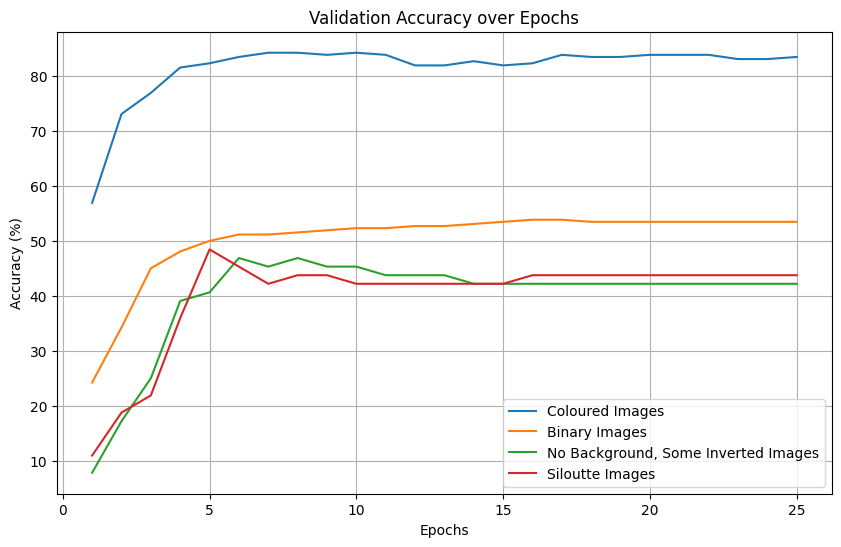

In [ ]:
plt.figure(figsize=(10, 6))
legend = ['Coloured Images','Binary Images','No Background, Some Inverted Images','Siloutte Images']
for i in range(1, 5):
    accuracy_list = globals()[f'accuracy_list_{i}']
    epochs = range(1, len(accuracy_list) + 1)
    plt.plot(epochs, accuracy_list, label=legend[i-1])

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.legend()  # Add legend
plt.grid(True)  # Add grid
plt.show()

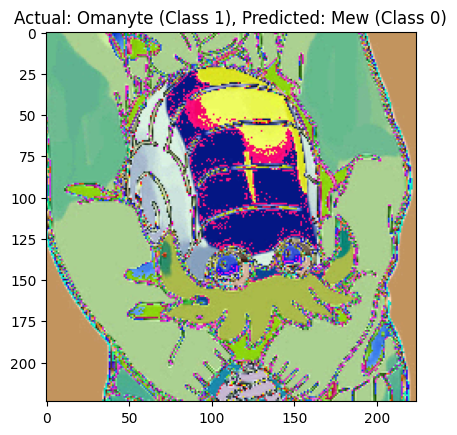

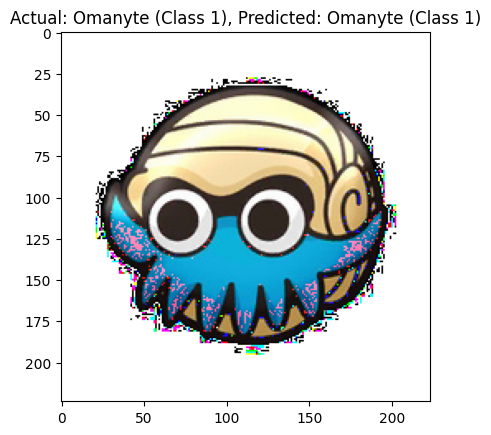

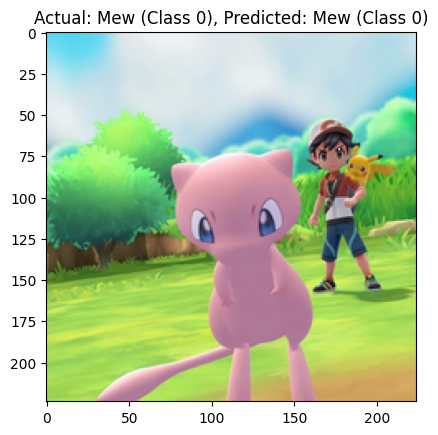

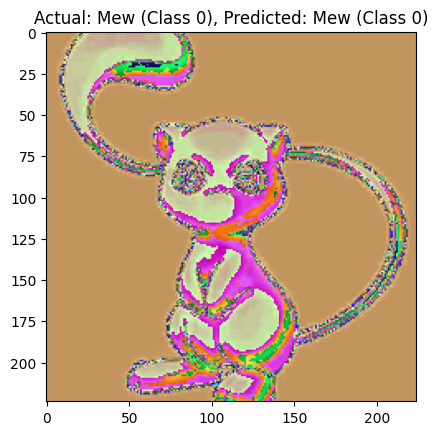

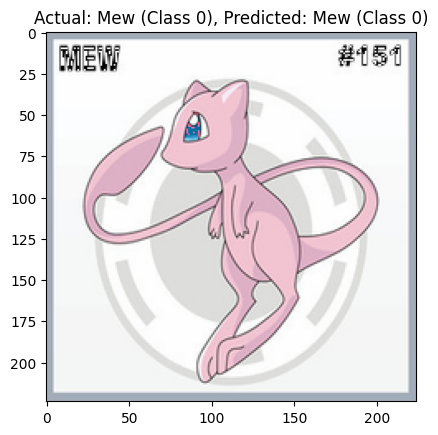

In [ ]:
# SHOWING MODEL PREDICITONS

def display_random_image_prediction(num_runs):
  for i in range(1,num_runs):
    index_to_display = random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[index_to_display]
    image = image.unsqueeze(0).to(device)
    logits = model(image.permute(0, 3, 1, 2))
    predicted_label = torch.argmax(logits).item()
    np_image = (image.squeeze().cpu().numpy() * 255).astype(np.uint8)
    np_image = 255 - np_image
    plt.imshow(np_image)
    plt.title(f"Actual: {pokemon_classes[label]} (Class {label}), Predicted: {pokemon_classes[predicted_label]} (Class {predicted_label})")
    plt.show()

display_random_image_prediction(3)
